### Michael Hotaling <br> DSC540: Term Project <br>12/24/2020

## Milestone 1 (Weeks 3 & 4)
### Identify Datasets

For my project, I'll be gathering information on insider trading among publically traded companies. Illegal insider trading is one of many types of financial frauds where insiders, defined as board members, executives and 10% share owners, use non-public information to buy or sell securities. 

### Web Scraping

The SEC requires all executives, board members, and 10% share owners to disclose their security transactions via Form 4. These forms are available on the SEC's Electronic Data Gathering, Analysis, and Retrieval system (EDGAR) and are added to the system in [real time.](https://www.sec.gov/cgi-bin/browse-edgar?company=&CIK=&type=4&owner=only&count=40&action=getcurrent)
___

![Jeff Bezos selling millions of dollars of Amazon Stock](images/form4.png)

___
The SEC provides this data in HTML and TXT formats and allows web scraping for these files. Many websites also have this information available in an easier to access format, but with a delay. I'll be attempting to gather the data directly from the SEC, but if this is not possible within the scope of this class, I'll be scraping the data from [Openinsider](www.openinsider.com)

In [25]:
import pandas as pd

ticker = "AMZN"

df = pd.DataFrame()
url = 'http://openinsider.com/screener?s={}&o=&pl=&ph=&ll=&lh=&fd=730&fdr=&td=0&tdr=&fdlyl=&fdlyh=&daysago=&xp=1&xs=1&vl=&vh=&ocl=&och=&sic1=-1&sicl=100&sich=9999&grp=0&nfl=&nfh=&nil=&nih=&nol=&noh=&v2l=&v2h=&oc2l=&oc2h=&sortcol=0&cnt=100&page='.format(ticker)

for i in range(1,100):
    tab = pd.read_html(url+str(i))
    if tab[11].columns[1] == 1:
        break
    df = pd.concat([df,tab[11]])

df = df.reset_index()
df

,index,X,Filing Date,Trade Date,Ticker,Insider Name,Insider Title,Trade Type,Price,Qty,Owned,ΔOwn,Value,1d,1w,1m,6m
0,0,NaN,2020-12-03 16:48:47,2020-12-01,AMZN,Wilke Jeffrey A,CEO Worldwide Consumer,S - Sale,"$3,200.59",-2000,48858,-4%,"-$6,401,175",NaN,NaN,NaN,NaN
1,1,NaN,2020-11-25 16:51:21,2020-11-23,AMZN,Wilke Jeffrey A,CEO Worldwide Consumer,S - Sale,"$3,091.15",-750,50858,-1%,"-$2,318,360",NaN,NaN,NaN,NaN
2,2,NaN,2020-11-24 17:04:23,2020-11-20,AMZN,Huttenlocher Daniel P,Dir,S - Sale,"$3,114.79",-172,950,-15%,"-$535,744",NaN,NaN,NaN,NaN
3,3,D,2020-11-17 17:29:49,2020-11-16,AMZN,Wilke Jeffrey A,CEO Worldwide Consumer,S - Sale+OE,"$3,114.36",-1200,51608,-2%,"-$3,737,229",NaN,NaN,NaN,NaN
4,4,D,2020-11-17 16:56:30,2020-11-16,AMZN,Jassy Andrew R,CEO Amazon Web Services,S - Sale+OE,"$3,085.62",-1099,84782,-1%,"-$3,391,096",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,3,D,2019-02-20 18:08:54,2019-02-15,AMZN,Blackburn Jeffrey M,SVP,S - Sale+OE,"$1,616.34",-2055,67459,-3%,"-$3,321,570",NaN,NaN,NaN,NaN
104,4,D,2019-02-20 18:08:16,2019-02-15,AMZN,Jassy Andrew R,CEO Amazon Web Services,S - Sale+OE,"$1,618.79",-1644,95568,-2%,"-$2,661,295",NaN,NaN,NaN,NaN
105,5,D,2019-02-20 18:07:39,2019-02-15,AMZN,Olsavsky Brian T,"SVP, CFO",S - Sale+OE,"$1,627.86",-2030,1068,-66%,"-$3,304,556",NaN,NaN,NaN,NaN
106,6,D,2019-02-20 18:06:55,2019-02-15,AMZN,Zapolsky David,SVP,S - Sale+OE,"$1,619.37",-1015,2851,-26%,"-$1,643,665",NaN,NaN,NaN,NaN


### CSV Files

Another important side of detecting insider information is evaluating whether or not these transactions were fiscally beneficial for these members. Since our Form 4 data only shows a snapshot of how many shares and the total value of the transactions, we will need an outside data source to provide the share price information before and after the transactions were made.

Yahoo Finance offers downloadable CSV files on their website and lets us pick our time ranges to select how much data we would like to download. We can directly import this CSV file into pandas using `pd.read_csv(url)`

In [26]:
import time
import datetime

def date_to_stamp(s):
    return round(time.mktime(datetime.datetime.strptime(s, "%m/%d/%Y").timetuple()))

In [30]:
ticker = "AMZN"
start_date = '1/10/2010'
end_date = datetime.date.today().strftime("%m/%d/%Y")

url = "https://query1.finance.yahoo.com/v7/finance/download/{}?period1={}&period2={}&interval=1d&events=history&includeAdjustedClose=true".format(ticker,date_to_stamp(start_date), date_to_stamp(end_date))

df = pd.read_csv(url)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-11,132.619995,132.800003,129.210007,130.309998,130.309998,8779400
1,2010-01-12,128.990005,129.820007,126.550003,127.349998,127.349998,9096300
2,2010-01-13,127.900002,129.710007,125.750000,129.110001,129.110001,10723200
3,2010-01-14,129.139999,130.380005,126.400002,127.349998,127.349998,9774900
4,2010-01-15,129.179993,129.649994,127.059998,127.139999,127.139999,15376500
...,...,...,...,...,...,...,...
2754,2020-12-17,3250.000000,3263.510010,3221.000000,3236.080078,3236.080078,3474300
2755,2020-12-18,3243.989990,3249.419922,3171.600098,3201.649902,3201.649902,5995700
2756,2020-12-21,3200.010010,3226.969971,3166.000000,3206.179932,3206.179932,3836800
2757,2020-12-22,3202.840088,3222.000000,3180.080078,3206.520020,3206.520020,2369400


We can add some common 'technical indicators' such as 50 day moving averages and 200 day moving averages to our dataset to help us determine the general momentum of the stock as well as add Bollinger Bands which are commonly used to evaluate the volatility of a stock

In [31]:
# Adding Moving Averages
df['50MA'] = df['Adj Close'].rolling(window=50).mean()
df['200MA'] = df['Adj Close'].rolling(window=200).mean()

# Adding Bollinger Bands 
df['middle_band'] = df['Adj Close'].rolling(window=20).mean()
df['upper_band'] = df['Adj Close'].rolling(window=20).mean() + df['Adj Close'].rolling(window=20).std()*2
df['lower_band'] = df['Adj Close'].rolling(window=20).mean() - df['Adj Close'].rolling(window=20).std()*2

df

,Date,Open,High,Low,Close,Adj Close,Volume,50MA,200MA,middle_band,upper_band,lower_band
0,2010-01-11,132.619995,132.800003,129.210007,130.309998,130.309998,8779400,NaN,NaN,NaN,NaN,NaN
1,2010-01-12,128.990005,129.820007,126.550003,127.349998,127.349998,9096300,NaN,NaN,NaN,NaN,NaN
2,2010-01-13,127.900002,129.710007,125.750000,129.110001,129.110001,10723200,NaN,NaN,NaN,NaN,NaN
3,2010-01-14,129.139999,130.380005,126.400002,127.349998,127.349998,9774900,NaN,NaN,NaN,NaN,NaN
4,2010-01-15,129.179993,129.649994,127.059998,127.139999,127.139999,15376500,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2754,2020-12-17,3250.000000,3263.510010,3221.000000,3236.080078,3236.080078,3474300,3185.954189,2812.730848,3160.538513,3252.709567,3068.367459
2755,2020-12-18,3243.989990,3249.419922,3171.600098,3201.649902,3201.649902,5995700,3186.176186,2819.233647,3164.770007,3256.297186,3073.242828
2756,2020-12-21,3200.010010,3226.969971,3166.000000,3206.179932,3206.179932,3836800,3184.566787,2826.261497,3170.109009,3257.964451,3082.253566
2757,2020-12-22,3202.840088,3222.000000,3180.080078,3206.520020,3206.520020,2369400,3179.838589,2832.834998,3175.515515,3257.927539,3093.103491


In [32]:
import matplotlib.pyplot as plt

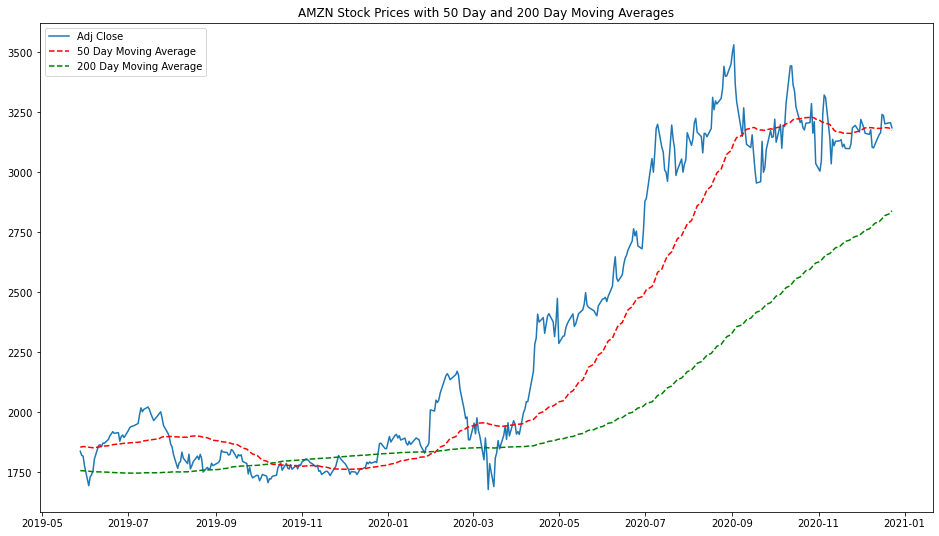

In [33]:
plt.figure(figsize=(16,9))
plt.title("{} Stock Prices with 50 Day and 200 Day Moving Averages".format(ticker))
plt.plot(pd.to_datetime(df['Date']).iloc[-400:], df['Adj Close'].iloc[-400:], label="Adj Close")
plt.plot(pd.to_datetime(df['Date']).iloc[-400:], df['50MA'].iloc[-400:], 'r--', label = "50 Day Moving Average" )
plt.plot(pd.to_datetime(df['Date']).iloc[-400:], df['200MA'].iloc[-400:], 'g--', label = "200 Day Moving Average" );
plt.legend()
plt.show()

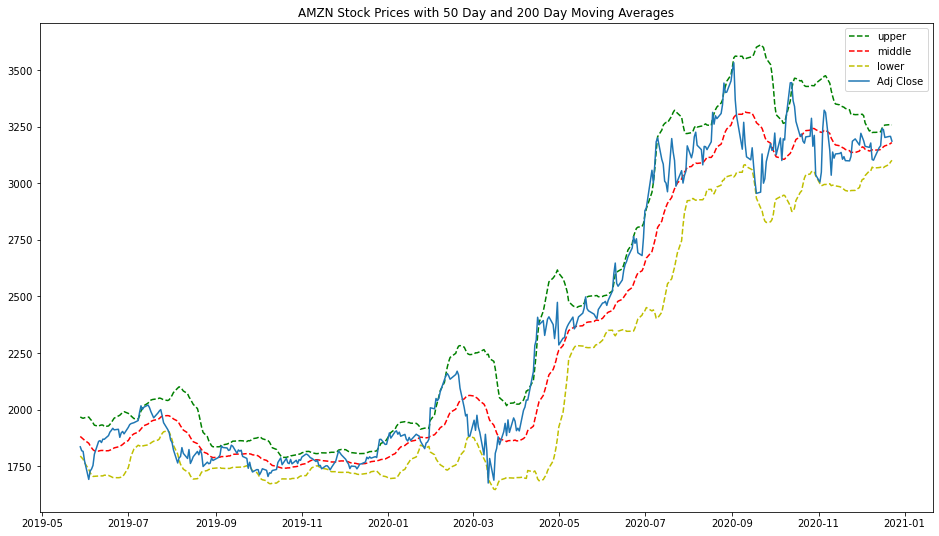

In [34]:
plt.figure(figsize=(16,9))
plt.title("{} Stock Prices with 50 Day and 200 Day Moving Averages".format(ticker))
plt.plot(pd.to_datetime(df['Date']).iloc[-400:], df['upper_band'].iloc[-400:], 'g--', label="upper")
plt.plot(pd.to_datetime(df['Date']).iloc[-400:], df['middle_band'].iloc[-400:], 'r--', label="middle")
plt.plot(pd.to_datetime(df['Date']).iloc[-400:], df['lower_band'].iloc[-400:], 'y--', label="lower")
plt.plot(pd.to_datetime(df['Date']).iloc[-400:], df['Adj Close'].iloc[-400:], label="Adj Close")
plt.legend()
plt.show()

### API Source
Finally, we will need to determine whether or not non-public information gave these insiders an advantage. Each fiscal year and quarter, publically traded companies must disclose their finances to the SEC. These yearly and quarterly reports (10-K and 10-Q) contain information about revenue, cash flows, liabilities, and several other metrics that are extremely impactful to the value of a company, and therefore, the stock prices. 

I originally was able to also scrape this information from the SEC by accessing the `master.idx` file, which contains all the filings and locations where they are stored. This ended up being a lot more difficult than I imagined

In [35]:
import os

years = range(2000,2021)
quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']
base_path = 'C:\\Users\\hotal\\Documents\\DSC540\\Finals'
current_dirs = os.listdir(path=base_path)

for yr in years:
    if str(yr) not in current_dirs:
        os.mkdir('/'.join([base_path, str(yr)]))
    current_files = os.listdir('/'.join([base_path, str(yr)]))
    
    for qtr in quarters:
        local_filename =  f'xbrl-index-{yr}-{qtr}.txt'
        local_file_path = '/'.join([base_path, str(yr), local_filename])
        if local_filename in current_files:
            continue
        url = f'https://www.sec.gov/Archives/edgar/full-index/{yr}/{qtr}/xbrl.idx'
        r = requests.get(url, stream=True)
        with open(local_file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=10240):
                f.write(chunk)
        time.sleep(1)

Before continuing, we need to convert our ticker into a CIK value, which is unique to each security. CIK values are always consistant, even if a companies ticker value changes. A dictionary of ticker values is available on the SEC website, were we can download it and extract the CIK value.

In [36]:
def ticker_downloader():
    tickers = pd.read_table("https://www.sec.gov/include/ticker.txt", names = ['Ticker', "CIK"])
    tickers.to_csv("ticker.csv")
    
def ticker_to_cik(ticker):
    """Returns the CIK value for a given ticker"""
    tickers = pd.read_csv("ticker.csv")
    ticker = ticker.replace(".","-")
    return int(tickers[tickers['Ticker'] == ticker.lower()]["CIK"])
    
ticker_downloader()

In [37]:
ticker_to_cik(ticker)

1018724

In [38]:
super_frame = pd.DataFrame(columns = ["CIK", "Company Name", "Form Type","Date Filed","Filename"])

for i in range(2000,2021):
    for j in range(1,5):
        df = pd.read_table("{}/xbrl-index-{}-QTR{}.txt".format(i,i,j),sep="|", skiprows=10, 
                           names = ["CIK", "Company Name", "Form Type","Date Filed","Filename"])
        super_frame = super_frame.append(df, ignore_index=True)

df = super_frame[((super_frame['Form Type'] == "10-K")|(super_frame['Form Type'] == "10-Q")) & (super_frame['CIK'] == ticker_to_cik(ticker))]
df.tail(10)

,CIK,Company Name,Form Type,Date Filed,Filename
303928,1018724,AMAZON COM INC,10-Q,2018-07-27,edgar/data/1018724/0001018724-18-000108.txt
311616,1018724,AMAZON COM INC,10-Q,2018-10-26,edgar/data/1018724/0001018724-18-000159.txt
319365,1018724,AMAZON COM INC,10-K,2019-02-01,edgar/data/1018724/0001018724-19-000004.txt
326782,1018724,AMAZON COM INC,10-Q,2019-04-26,edgar/data/1018724/0001018724-19-000043.txt
335637,1018724,AMAZON COM INC,10-Q,2019-07-26,edgar/data/1018724/0001018724-19-000071.txt
346417,1018724,AMAZON COM INC,10-Q,2019-10-25,edgar/data/1018724/0001018724-19-000089.txt
360739,1018724,AMAZON COM INC,10-K,2020-01-31,edgar/data/1018724/0001018724-20-000004.txt
376325,1018724,AMAZON COM INC,10-Q,2020-05-01,edgar/data/1018724/0001018724-20-000010.txt
395062,1018724,AMAZON COM INC,10-Q,2020-07-31,edgar/data/1018724/0001018724-20-000021.txt
411570,1018724,AMAZON COM INC,10-Q,2020-10-30,edgar/data/1018724/0001018724-20-000030.txt


Now, we have the current directory of each filing. We can then parse through the information to extract the data we need

In [39]:
urls = "https://www.sec.gov/Archives/" + df['Filename']
for ind, i in enumerate(urls):
    print(i)
    if ind > 4:
        break

https://www.sec.gov/Archives/edgar/data/1018724/0001193125-09-154174.txt
https://www.sec.gov/Archives/edgar/data/1018724/0001193125-09-212134.txt
https://www.sec.gov/Archives/edgar/data/1018724/0001193125-10-016098.txt
https://www.sec.gov/Archives/edgar/data/1018724/0001193125-10-090367.txt
https://www.sec.gov/Archives/edgar/data/1018724/0001193125-10-164083.txt
https://www.sec.gov/Archives/edgar/data/1018724/0001193125-10-233883.txt


In [40]:
urls_json = []

for i in urls:
    urls_json.append(i.replace("-","").replace(".txt",'/index.json'))
for ind, i in enumerate(urls_json):
    print(i)
    if ind > 4:
        break

https://www.sec.gov/Archives/edgar/data/1018724/000119312509154174/index.json
https://www.sec.gov/Archives/edgar/data/1018724/000119312509212134/index.json
https://www.sec.gov/Archives/edgar/data/1018724/000119312510016098/index.json
https://www.sec.gov/Archives/edgar/data/1018724/000119312510090367/index.json
https://www.sec.gov/Archives/edgar/data/1018724/000119312510164083/index.json
https://www.sec.gov/Archives/edgar/data/1018724/000119312510233883/index.json


In [41]:
import requests

content = requests.get(urls_json[-1]).json()

for file in content['directory']['item']:
    if file['name'] == 'FilingSummary.xml':
        xml_summary = "https://www.sec.gov" + content['directory']['name'] + "/" + file['name']
        print(xml_summary)

https://www.sec.gov/Archives/edgar/data/1018724/000101872420000030/FilingSummary.xml


In [42]:
from bs4 import BeautifulSoup

base_url = xml_summary.replace('FilingSummary.xml',"")
content = requests.get(xml_summary).content
soup = BeautifulSoup(content, 'lxml')
reports = soup.find('myreports')

In [43]:
master_reports = []

for report in reports.find_all('report')[:-1]:
    report_dict = {}
    report_dict['shortname'] = report.shortname.text
    report_dict['longname'] = report.longname.text
    report_dict['position'] = report.position.text
    report_dict['menucategory'] = report.menucategory.text
    report_dict['filename'] = base_url + report.htmlfilename.text
    
    master_reports.append(report_dict)

In [44]:
testdf = pd.DataFrame(master_reports)
testdf[testdf['menucategory'] == 'Statements']['shortname']

1                Consolidated Statements of Cash Flows
2                Consolidated Statements of Operations
3      Consolidated Statements of Comprehensive Income
4    Consolidated Statements of Comprehensive Incom...
5                          Consolidated Balance Sheets
6          Consolidated Balance Sheets (Parenthetical)
Name: shortname, dtype: object

In [45]:
statements_url = []

for report_dict in master_reports:
    """Everything is named differently so I'll need to do some fancy regex work to get this to work"""
    
    item1 = "Consolidated Balance Sheets".upper()
    item2 = "Consolidated Statements of Comprehensive Income".upper()
    item3 = "Consolidated Statements of Cash Flows".upper()
    
    report_list = [item1,item2,item3]
    
    if report_dict['shortname'].upper() in report_list:
        print(report_dict['shortname'])
        print(report_dict['filename'])
        statements_url.append(report_dict['filename'])

Consolidated Statements of Cash Flows
https://www.sec.gov/Archives/edgar/data/1018724/000101872420000030/R2.htm
Consolidated Statements of Comprehensive Income
https://www.sec.gov/Archives/edgar/data/1018724/000101872420000030/R4.htm
Consolidated Balance Sheets
https://www.sec.gov/Archives/edgar/data/1018724/000101872420000030/R6.htm


In [46]:
statements_data = []

for statement in statements_url:
    statement_data = {}
    statement_data['header'] = []
    statement_data['section'] = []
    statement_data['data'] = []
    content = requests.get(statement).content
    report_soup = BeautifulSoup(content,"html")
    for index, row in enumerate(report_soup.table.find_all('tr')):
        cols = row.find_all('td')
        if (len(row.find_all('th'))) == 0 and (len(row.find_all('strong')) == 0):
            reg_row = [ele.text.strip() for ele in cols]
            statement_data['data'].append(reg_row)
        elif (len(row.find_all('th')) == 0 and len(row.find_all('strong')) != 0):
            sec_row = cols[0].text.strip()
            statement_data['section'].append(sec_row)
        elif (len(row.find_all('th'))!= 0):
            hed_row = [ele.text.strip() for ele in row.find_all('th')]
            statement_data['header'].append(hed_row)
    statements_data.append(statement_data)
    
pd.DataFrame(statements_data)

,header,section,data
0,[[Consolidated Statements of Cash Flows - USD ...,"[Statement of Cash Flows [Abstract], OPERATING...","[[CASH, CASH EQUIVALENTS, AND RESTRICTED CASH,..."
1,[[Consolidated Statements of Comprehensive Inc...,"[Statement of Comprehensive Income [Abstract],...","[[Net income, $ 6,331, $ 2,134, $ 14,109, $ 8,..."
2,[[Consolidated Balance Sheets - USD ($) $ in M...,"[Current assets:, Current liabilities:, Stockh...","[[Cash and cash equivalents, $ 29,930, $ 36,09..."


In [47]:
income_header = statements_data[1]['header'][1]
income_data = statements_data[1]['data']

income_df = pd.DataFrame(income_data)

income_df.index = income_df[0]
income_df.index.name = 'Category'
income_df = income_df.drop(0,axis=1)
income_df = income_df.replace('[\$,)]',"", regex=True)
income_df = income_df.replace('[(]',"-", regex = True)
income_df = income_df.replace('', 'NaN', regex = True)
income_df = income_df.astype(float)
income_df.columns = income_header

income_df

,"Sep. 30, 2020","Sep. 30, 2019","Sep. 30, 2020","Sep. 30, 2019"
Category,,,,
Net income,6331.0,2134.0,14109.0,8320.0
"Foreign currency translation adjustments, net of tax of $1, $(15), $(6) and $(2)",408.0,-368.0,-260.0,-369.0
"Reclassification adjustment for foreign currency translation included in “Other operating expense (income), net,” net of tax of $29, $0, $29 and $0",0.0,-108.0,0.0,-108.0
Net foreign currency translation adjustments,408.0,-476.0,-260.0,-477.0
"Unrealized gains (losses), net of tax of $(2), $(10), $(13) and $(73)",35.0,9.0,239.0,85.0
"Reclassification adjustment for losses (gains) included in “Other income (expense), net,” net of tax of $0, $5, $0 and $7",-17.0,-2.0,-22.0,-2.0
Net unrealized gains (losses) on available-for-sale debt securities,18.0,7.0,217.0,83.0
Other comprehensive income (loss),426.0,-469.0,-43.0,-394.0
Comprehensive income,6757.0,1665.0,14066.0,7926.0


In [48]:
income_header = statements_data[0]['header']
income_data = statements_data[0]['data']

income_df = pd.DataFrame(income_data)

income_df.index = income_df[0]
income_df.index.name = 'Category'
income_df = income_df.drop(0,axis=1)
income_df = income_df.replace('[\$,)]',"", regex=True)
income_df = income_df.replace('[(]',"-", regex = True)
income_df = income_df.replace('', 'NaN', regex = True)
income_df = income_df.astype(float)
income_df.columns = income_header[1]

income_df

,"Sep. 30, 2020","Sep. 30, 2019","Sep. 30, 2020","Sep. 30, 2019","Sep. 30, 2020","Sep. 30, 2019"
Category,,,,,,
"CASH, CASH EQUIVALENTS, AND RESTRICTED CASH, BEGINNING OF PERIOD",37842.0,22965.0,36410.0,32173.0,23554.0,21032.0
Net income,6331.0,2134.0,14109.0,8320.0,17377.0,11347.0
"Depreciation and amortization of property and equipment and capitalized content costs, operating lease assets, and other",6523.0,5563.0,17633.0,15619.0,23803.0,19881.0
Stock-based compensation,2288.0,1779.0,6646.0,5024.0,8486.0,6441.0
"Other operating expense (income), net",67.0,47.0,416.0,114.0,466.0,186.0
"Other expense (income), net",-1051.0,388.0,-1255.0,246.0,-1749.0,443.0
Deferred income taxes,295.0,92.0,1082.0,612.0,1267.0,784.0
Inventories,-3899.0,-381.0,-3178.0,-1762.0,-4694.0,-3112.0
"Accounts receivable, net and other",-2016.0,-1181.0,-3608.0,-3776.0,-7515.0,-5172.0


In [49]:
income_header = statements_data[2]['header'][0][1::]
income_data = statements_data[2]['data']

income_df = pd.DataFrame(income_data)

income_df.index = income_df[0]
income_df.index.name = 'Category'
income_df = income_df.drop(0,axis=1)
income_df = income_df.replace('[\$,)]',"", regex=True)
income_df = income_df.replace('[(]',"-", regex = True)
income_df = income_df.replace('', 'NaN', regex = True)
income_df = income_df.astype(float)
income_df.columns = income_header
income_df

,"Sep. 30, 2020","Dec. 31, 2019"
Category,,
Cash and cash equivalents,29930.0,36092.0
Marketable securities,38472.0,18929.0
Inventories,23735.0,20497.0
"Accounts receivable, net and other",20832.0,20816.0
Total current assets,112969.0,96334.0
"Property and equipment, net",99981.0,72705.0
Operating leases,34119.0,25141.0
Goodwill,14960.0,14754.0
Other assets,20150.0,16314.0


---
In the end, I was able to extract all three tables using the `xbrl` formatting provided by the SEC. Unfortunately, each company has a different structure to their data, so extracting multiple data for multiple companies is very difficult without manual intervention. 

I decided to go with an API for this portion to save me the headache. I'll be using the SimFim API, which will allow me to pull basic financial records for each company. 

In [50]:
with open("apikey.txt","r") as f:
    api_key = f.readline()

periods = ["q1", "q2", "q3", "q4"]
year_start = 2012
year_end = 2020

# request url for all financial statements
request_url = 'https://simfin.com/api/v2/companies/statements'

# variable to store the names of the columns
columns = []
# variable to store our data
output = []

for year in range(year_start, year_end + 1):
    # loop through periods
    for period in periods:
        # define the parameters for the query
        parameters = {"statement": "all", "ticker": ticker, "period": period, "fyear": year, "api-key": api_key}
        # make the request
        request = requests.get(request_url, parameters)

        # convert response to json and take 0th index as we only requested one ticker (if more than one ticker is requested, the data for the nth ticker will be at the nth position in the result returned from the API)
        data = request.json()[0]

        # make sure that data was found
        if data['found'] and len(data['data']) > 0:
            # add the column descriptions once only
            if len(columns) == 0:
                columns = data['columns']
            # add the data
            output += data['data']

df = pd.DataFrame(output, columns=columns)
df

,SimFinId,Ticker,Fiscal Period,Fiscal Year,Report Date,Publish Date,Restated Date,Source,TTM,Value Check,...,Current Ratio,Liabilities to Equity Ratio,Debt Ratio,"Earnings Per Share, Basic","Earnings Per Share, Diluted",Sales Per Share,Equity Per Share,Free Cash Flow Per Share,Dividends Per Share,Pietroski F-Score
0,62747,AMZN,Q1,2012,2012-03-31,2012-04-26,2013-04-26,https://www.sec.gov/Archives/edgar/data/101872...,False,True,...,1.16142,1.79728,0.00000,0.28698,0.28261,29.10596,16.05077,-5.71965,None,3
1,62747,AMZN,Q2,2012,2012-06-30,2012-07-26,2013-07-26,https://www.sec.gov/Archives/edgar/data/101872...,False,True,...,1.07798,1.80107,0.00000,0.01552,0.01528,28.45676,16.64080,3.15078,None,5
2,62747,AMZN,Q3,2012,2012-09-30,2012-10-25,2013-10-25,https://www.sec.gov/Archives/edgar/data/101872...,False,True,...,1.04371,2.02317,0.00000,-0.60619,-0.60619,30.54425,16.71018,1.37389,None,4
3,62747,AMZN,Q4,2012,2012-12-31,2013-01-26,2015-01-30,https://www.sec.gov/Archives/edgar/data/101872...,False,True,...,1.12072,2.97400,0.09473,0.21491,0.22172,46.64035,17.96491,6.73465,None,5
4,62747,AMZN,Q1,2013,2013-03-31,2013-04-25,2014-04-25,https://www.sec.gov/Archives/edgar/data/101872...,False,True,...,1.14680,2.36539,0.10713,0.18022,0.17711,35.31868,18.53187,-6.04176,None,2
5,62747,AMZN,Q2,2013,2013-06-30,2013-07-25,2014-07-25,https://www.sec.gov/Archives/edgar/data/101872...,False,True,...,1.11388,2.39208,0.10269,-0.01535,-0.01535,34.43860,19.15132,2.99781,None,5
6,62747,AMZN,Q3,2013,2013-09-30,2013-10-24,2014-10-24,https://www.sec.gov/Archives/edgar/data/101872...,False,True,...,1.08224,2.50622,0.09551,-0.08972,-0.08972,37.40044,19.88403,1.30197,None,5
7,62747,AMZN,Q4,2013,2013-12-31,2014-01-25,2016-01-29,https://www.sec.gov/Archives/edgar/data/101872...,False,True,...,1.07158,3.12056,0.07946,0.52174,0.49587,55.62174,21.18696,9.91522,None,6
8,62747,AMZN,Q1,2014,2014-03-31,2014-04-24,2015-04-24,https://www.sec.gov/Archives/edgar/data/101872...,False,True,...,1.05284,2.52091,0.08654,0.23478,0.23077,42.91522,22.45217,-5.95435,None,4
9,62747,AMZN,Q2,2014,2014-06-30,2014-07-24,2015-07-24,https://www.sec.gov/Archives/edgar/data/101872...,False,True,...,1.00021,2.57461,0.08230,-0.27332,-0.27332,41.95228,22.99783,6.39913,None,4


In [51]:
list(df.columns)

['SimFinId',
 'Ticker',
 'Fiscal Period',
 'Fiscal Year',
 'Report Date',
 'Publish Date',
 'Restated Date',
 'Source',
 'TTM',
 'Value Check',
 'Revenue',
 'Sales & Services Revenue',
 'Financing Revenue',
 'Other Revenue',
 'Cost of Revenue',
 'Cost of Goods & Services',
 'Cost of Financing Revenue',
 'Cost of Other Revenue',
 'Gross Profit',
 'Other Operating Income',
 'Operating Expenses',
 'Selling, General & Administrative',
 'Selling & Marketing',
 'General & Administrative',
 'Research & Development',
 'Depreciation & Amortization',
 'Provision for Doubtful Accounts',
 'Other Operating Expenses',
 'Operating Income (Loss)',
 'Non-Operating Income (Loss)',
 'Interest Expense, Net',
 'Interest Expense',
 'Interest Income',
 'Other Investment Income (Loss)',
 'Foreign Exchange Gain (Loss)',
 'Income (Loss) from Affiliates',
 'Other Non-Operating Income (Loss)',
 'Pretax Income (Loss), Adj.',
 'Abnormal Gains (Losses)',
 'Acquired In-Process R&D',
 'Merger & Acquisition Expense',
 